In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import bayespy as bp
import numpy as np

/home/main/anaconda2/envs/python3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/main/anaconda2/envs/python3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Simple Example from [bayespy.org]()

Iteration 1: loglike=-6.005372e+01 (0.002 seconds)
Iteration 2: loglike=-5.806491e+01 (0.002 seconds)
Iteration 3: loglike=-5.806254e+01 (0.002 seconds)
Iteration 4: loglike=-5.806252e+01 (0.002 seconds)
Converged at iteration 4.


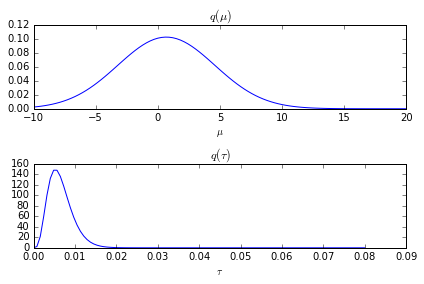

In [2]:
data = np.random.normal(5,10, size=(10,))
from bayespy.nodes import GaussianARD, Gamma
mu = GaussianARD(0, 1e-6)
tau = Gamma(1e-6, 1e-6)
y = GaussianARD(mu, tau, plates=(10,))

y.observe(data)

from bayespy.inference import VB
Q = VB(mu, tau, y)
Q.update(repeat=20)

bp.plot.pyplot.subplot(2,1,1)
bp.plot.pdf(mu, np.linspace(-10,20, num=100), name=r'\mu')
bp.plot.pyplot.subplot(2,1,2)
bp.plot.pdf(tau, np.linspace(1e-6,.08,num=100), name=r'\tau')
bp.plot.pyplot.tight_layout()
bp.plot.pyplot.show()


## Gaussian Process Example

In [44]:
from scipy.spatial import distance


# Some 3-dimensional inputs
N = 200
X = np.random.randn(N, 3)

def dist(X):
    return distance.squareform(distance.pdist(X))


# Squared distance matrix
D = dist(X) ** 2

idx = 0
n_iter = 50
gp_len = np.zeros((n_iter,1))
gp_mag = np.zeros((n_iter,1))
noise_std = np.zeros((n_iter,1))

while idx < n_iter:

    def exponentiated_square(parameters):
        lengthscale = np.exp(parameters[0])
        return np.exp(-D/lengthscale) + 1e-6 * np.identity(N)


    def d_parameters(d_exponentiated_square, parameters):
        """ Backward gradient of exponentiated square w.r.t. parameters """
        lengthscale = np.exp(parameters[0])
        K = np.exp(-D/lengthscale)
        return [
            np.sum(d_exponentiated_square * K * D / lengthscale),
        ]


    def inverse(K):
        return np.linalg.inv(K)


    def d_covariance(d_inverse, K):
        """ Backward gradient of inverse w.r.t. covariance """
        invK = np.linalg.inv(K)
        return -np.dot(invK, np.dot(d_inverse, invK))


    parameters = bp.nodes.MaximumLikelihood(np.log([1]))
    Covariance = bp.nodes.Function(
        exponentiated_square,
        (parameters, d_parameters)
    )
    Lambda = bp.nodes.Function(
        inverse,
        (Covariance, d_covariance)
    )

    magnitude = bp.nodes.Gamma(1e-3, 1e-3)
    # magnitude = bp.nodes.Gamma(10, 10)

    scaled_Lambda = bp.nodes.Wishart.scale(Lambda, magnitude, ndim=1)

    # Latent Gaussian process
    latent = bp.nodes.Gaussian(np.zeros(N), scaled_Lambda)

    # Observation noise precision
    tau = bp.nodes.Gamma(1e-3, 1e-3)

    # Observations node
    Y = bp.nodes.GaussianARD(latent, tau)

    # Create data
    K = 10**2 * exponentiated_square(np.log([0.3]))
    data = bp.nodes.Gaussian(np.zeros(N), np.linalg.inv(K + 0.1**2*np.identity(N))).random()
    Y.observe(data)

    # Run inference:
    Q = bp.inference.VB(Y, latent, magnitude, tau, parameters)
    Q.optimize(parameters, magnitude, tau, collapsed=[latent], maxiter=200, verbose=False)

    #print("Learned GP lengthscale:", np.exp(parameters.get_moments()[0]))
    #print("Learned GP magnitude:", magnitude.get_moments()[0] ** (-0.5))
    #print("Learned noise std:", tau.get_moments()[0] ** (-0.5))
    
    gp_len[idx] = np.exp(parameters.get_moments()[0])
    gp_mag[idx] = magnitude.get_moments()[0]**(-0.5)
    noise_std[idx] = tau.get_moments()[0]**(-0.5)
    idx = idx + 1


/home/main/anaconda2/envs/python3/lib/python3.5/site-packages/bayespy/inference/vmp/vmp.py:734: UserWarning: Lower bound decreased 6.402258e-06! Bug somewhere or numerical inaccuracy?
  "numerical inaccuracy?" % L_diff)


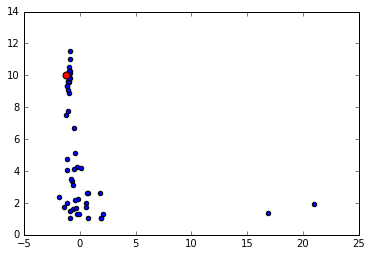

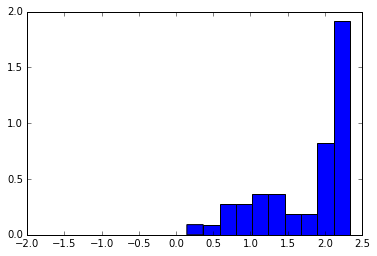

In [46]:
plt.scatter(np.log(gp_len), gp_mag)
plt.scatter(np.log(0.3), 10, s=50, c="red")
plt.figure()
n, bins, patches = plt.hist(np.log(noise_std), normed=True)
plt.plot([-2]*2, [0, np.max(n)], color="red",linewidth=2)